# NYC Taxi Fare & Duration
## Model Training

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wget
import pickle
import glob

sys.path.append("..")

import source.configs as configs
import preprocessing as preprocessing

# Check if we are in COLAB
IN_COLAB = 'google.colab' in sys.modules

Download dataset files (2022)

In [188]:
if IN_COLAB:
    !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet "../dataset"
else:
    for url in configs.TRAIN_DATASET_URLS:
        fname = url.split("/")[-1] 
        if not os.path.exists(f"../dataset/train/{fname}"):
            print(f"Downloading {fname}")
            wget.download(url, "../dataset/train")
        else:
            print(f"{fname} already in disk. Skipping download.")

yellow_tripdata_2022-05.parquet already in disk. Skipping download.


In [189]:
files_list = glob.glob("../dataset/train/*.parquet")
dataset_list = []
for file in files_list:
    print(f"Reading {file}")
    df_month = pd.read_parquet(file)
    dataset_list.append(df_month)
print("Pandas concat for dataframes...")
dataset = pd.concat(dataset_list, axis=0, ignore_index=True)
print("Done!")

Reading ../dataset/train\yellow_tripdata_2022-05.parquet
Pandas concat for dataframes...
Done!


In [190]:
dataset = dataset.copy().sample(100000)

In [177]:
print("Add targets")
dataset = preprocessing.add_targets(dataset)

print("Process outliers")
dataset = preprocessing.process_outliers(dataset, "delete")

if os.path.exists("avg_speed_dict.model"):
    with open("avg_speed_dict.model", "rb") as avg_speed_dict_fd:
        avg_speed_dict = pickle.load(avg_speed_dict_fd)
        print("Avereage speed dictionary", avg_speed_dict)
else:
    print("Error: Average speed dictionary not found!")

print("Add features")
dataset, _ = preprocessing.add_features(dataset, avg_speed_dict)

print("Fill na values")
dataset = preprocessing.fill_na_values(dataset)
print("Done!")

Add targets
Process outliers
Avereage speed dictionary {0: 0.25195469322838193, 1: 0.2503693835995309, 2: 0.24999335352944238, 3: 0.26612218282651856, 4: 0.31345897957385943, 5: 0.3355459231509819, 6: 0.27443853508122146, 7: 0.21423070424047383, 8: 0.18310836751240536, 9: 0.1801333123203435, 10: 0.17675564690190834, 11: 0.16859408041651547, 12: 0.16663810140450216, 13: 0.16766048469717576, 14: 0.16282710598596348, 15: 0.15792099847450106, 16: 0.16202178873469653, 17: 0.16106102095237498, 18: 0.16875892761499706, 19: 0.18793062365816957, 20: 0.207260086062618, 21: 0.21805265270227106, 22: 0.22578244300596678, 23: 0.24366564777182562}
Add features
Using pre-processed average speed dictionary
Fill na values
Done!


### Features
* trip_distance
* hour_of_day: Extracted from tpep_pickup_datetime
* avg_speed: trip_distance / trip_duration. It is stored to use during inference.
* trip_d2: Trip distance squared
* rush_hour: Extracted from tpep_pickup_datetime. Binary.
### Targets
* fare_amount
* trip_duration

In [191]:
columns = preprocessing.features + preprocessing.targets
train_dataset = preprocessing.select_features(dataset, columns)
train_dataset, encoders = preprocessing.create_one_hot_encodings(train_dataset, columns)
pickle.dump(encoders, open('encoders.model', 'wb'))

KeyError: "['hour_of_day', 'rush_hour', 'day_of_week', 'trip_d2', 'avg_speed', 'trip_duration'] not in index"

In [192]:
train_dataset.columns.to_list()

['trip_distance',
 'hour_of_day',
 'rush_hour',
 'day_of_week',
 'trip_d2',
 'avg_speed',
 'fare_amount',
 'trip_duration',
 'PULocationID_4',
 'PULocationID_7',
 'PULocationID_10',
 'PULocationID_12',
 'PULocationID_13',
 'PULocationID_17',
 'PULocationID_24',
 'PULocationID_25',
 'PULocationID_33',
 'PULocationID_37',
 'PULocationID_41',
 'PULocationID_42',
 'PULocationID_43',
 'PULocationID_45',
 'PULocationID_48',
 'PULocationID_49',
 'PULocationID_50',
 'PULocationID_52',
 'PULocationID_56',
 'PULocationID_57',
 'PULocationID_60',
 'PULocationID_63',
 'PULocationID_65',
 'PULocationID_66',
 'PULocationID_68',
 'PULocationID_70',
 'PULocationID_71',
 'PULocationID_74',
 'PULocationID_75',
 'PULocationID_78',
 'PULocationID_79',
 'PULocationID_82',
 'PULocationID_83',
 'PULocationID_87',
 'PULocationID_88',
 'PULocationID_90',
 'PULocationID_93',
 'PULocationID_97',
 'PULocationID_100',
 'PULocationID_107',
 'PULocationID_112',
 'PULocationID_113',
 'PULocationID_114',
 'PULocationI

In [193]:
for col in train_dataset.isna().sum():
    assert col==0
print("Ok, no NAs in train dataset!")

Ok, no NAs in train dataset!


In [194]:
train_dataset.describe()

,trip_distance,hour_of_day,rush_hour,day_of_week,trip_d2,avg_speed,fare_amount,trip_duration,PULocationID_4,PULocationID_7,...,DOLocationID_164,DOLocationID_196,DOLocationID_224,DOLocationID_229,DOLocationID_231,DOLocationID_234,DOLocationID_237,DOLocationID_246,DOLocationID_261,DOLocationID_263
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
train_dataset.columns.to_list()

['trip_distance',
 'hour_of_day',
 'rush_hour',
 'day_of_week',
 'trip_d2',
 'avg_speed',
 'fare_amount',
 'trip_duration',
 'PULocationID_4',
 'PULocationID_7',
 'PULocationID_10',
 'PULocationID_12',
 'PULocationID_13',
 'PULocationID_17',
 'PULocationID_24',
 'PULocationID_25',
 'PULocationID_33',
 'PULocationID_37',
 'PULocationID_41',
 'PULocationID_42',
 'PULocationID_43',
 'PULocationID_45',
 'PULocationID_48',
 'PULocationID_49',
 'PULocationID_50',
 'PULocationID_52',
 'PULocationID_56',
 'PULocationID_57',
 'PULocationID_60',
 'PULocationID_63',
 'PULocationID_65',
 'PULocationID_66',
 'PULocationID_68',
 'PULocationID_70',
 'PULocationID_71',
 'PULocationID_74',
 'PULocationID_75',
 'PULocationID_78',
 'PULocationID_79',
 'PULocationID_82',
 'PULocationID_83',
 'PULocationID_87',
 'PULocationID_88',
 'PULocationID_90',
 'PULocationID_93',
 'PULocationID_97',
 'PULocationID_100',
 'PULocationID_107',
 'PULocationID_112',
 'PULocationID_113',
 'PULocationID_114',
 'PULocationI

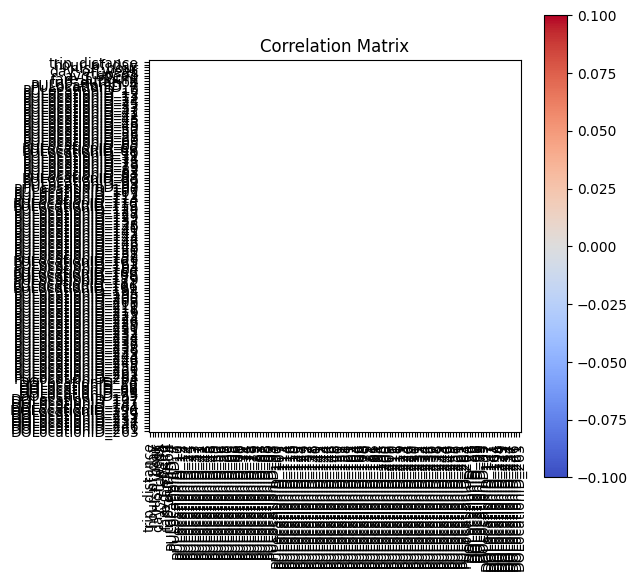

In [183]:
correlation_matrix = train_dataset.corr()
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Correlation Matrix')
plt.xticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns, rotation=90)
plt.yticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns)
plt.show()

## Model Training

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Split dataset

In [197]:
# Split features and targets
X, y = preprocessing.split_dataset(train_dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_td = y_train["trip_duration"]
y_train_fa = y_train["fare_amount"]

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## LINEAR MODEL

In [143]:
from sklearn.linear_model import LinearRegression
linreg_model_td = LinearRegression(n_jobs=-1)
linreg_model_fa = LinearRegression(n_jobs=-1)

In [144]:
print("Fit model TD")
linreg_model_td.fit(X_train, y_train_td.values.ravel());
print("Fit model FA")
linreg_model_fa.fit(X_train, y_train_fa.values.ravel());
print("Done!")

Fit model TD
Fit model FA
Done!


In [145]:
test_predictions_fa = linreg_model_fa.predict(X_test)
test_predictions_td = linreg_model_td.predict(X_test)

y_test_td = y_test["trip_duration"]
mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
r2_td = r2_score(y_test_td, test_predictions_td)
print(f"Trip duration MSE: {mse_td} minutes")
print(f"Trip duration R2: {r2_td}")

y_test_fa = y_test["fare_amount"]
mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
r2_fa = r2_score(y_test_fa, test_predictions_fa)
print(f"Fare amount MSE: {mse_fa} $")
print(f"Fare amount R2: {r2_fa}")

Trip duration MSE: 304.63675218713604 minutes
Trip duration R2: -1598.0215500652232
Fare amount MSE: 104.11159234929751 $
Fare amount R2: -197.66612282819472


In [146]:
pickle.dump(linreg_model_fa, open('linreg_model_fa.model', 'wb'))
pickle.dump(linreg_model_td, open('linreg_model_td.model', 'wb'))

## MODEL RANDOM FOREST

In [147]:
ENABLE_RF = True

In [148]:
if ENABLE_RF:
    from sklearn.ensemble import RandomForestRegressor
    rf_model_td = RandomForestRegressor(n_jobs=-1,
                                        n_estimators=10)
    rf_model_fa = RandomForestRegressor(n_jobs=-1,
                                        n_estimators=10)

In [149]:
if ENABLE_RF:
    print("Fit model TD")
    rf_model_td.fit(X_train, y_train_td.values.ravel());
    print("Fit model FA")
    rf_model_fa.fit(X_train, y_train_fa.values.ravel());
    print("Done!")

Fit model TD
Fit model FA
Done!


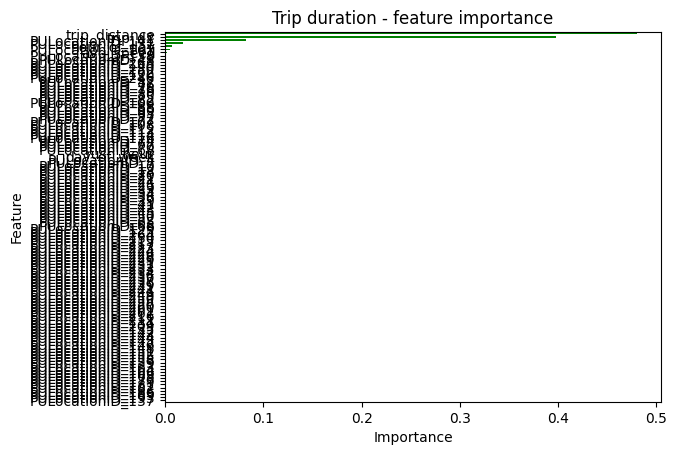

In [150]:
if ENABLE_RF:
    global_importances = pd.Series(rf_model_td.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Trip duration - feature importance")

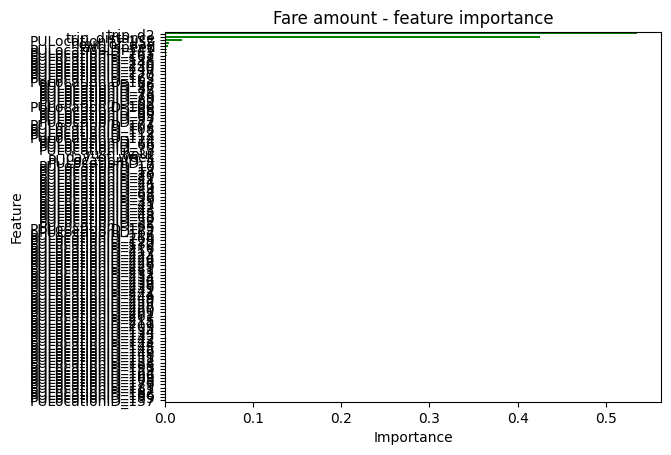

In [151]:
if ENABLE_RF:
    global_importances = pd.Series(rf_model_fa.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Fare amount - feature importance")

In [152]:
if ENABLE_RF:
    test_predictions_fa = rf_model_fa.predict(X_test)
    test_predictions_td = rf_model_td.predict(X_test)

    y_test_td = y_test["trip_duration"]
    mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
    r2_td = r2_score(y_test_td, test_predictions_td)
    print(f"Trip duration MSE: {mse_td} minutes")
    print(f"Trip duration R2: {r2_td}")

    y_test_fa = y_test["fare_amount"]
    mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
    r2_fa = r2_score(y_test_fa, test_predictions_fa)
    print(f"Fare amount MSE: {mse_fa} $")
    print(f"Fare amount R2: {r2_fa}")

Trip duration MSE: 4.218245817609231 minutes
Trip duration R2: 0.6934131715892007
Fare amount MSE: 1.414390328021229 $
Fare amount R2: 0.963333944281525


In [153]:
if ENABLE_RF:
    pickle.dump(rf_model_fa, open('rf_model_fa.model', 'wb'))
    pickle.dump(rf_model_td, open('rf_model_td.model', 'wb'))

## MODEL LIGHT GBM

In [154]:
print("Model LightGBM")
import lightgbm as lgb

train_data_lgb_td = lgb.Dataset(X_train, label=y_train_td)
train_data_lgb_fa = lgb.Dataset(X_train, label=y_train_fa)
params = {
    "objective": "regression",  # 'regression' for regression problems
    "metric": "rmse",  # Root Mean Squared Error for evaluation
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "num_leaves": 100,  # Maximum number of leaves in one tree
    "learning_rate": 0.05,  # Learning rate
    "feature_fraction": 0.9,  # Fraction of features to be used in each iteration
    "bagging_fraction": 0.8,  # Fraction of data to be used for bagging
    "bagging_freq": 5,  # Frequency for bagging
    "verbose": 1,  # Verbosity (0: silent, 1: progress bar, 2: print all)
}
num_rounds = 500  # Number of boosting rounds (iterations)

Model LightGBM


In [155]:
print("Training LGBM")
print("Fit model TD")
lgbm_model_td = lgb.train(params, train_data_lgb_td, num_rounds)
print("Fit model FA")
lgbm_model_fa = lgb.train(params, train_data_lgb_fa, num_rounds)
print("Done!")

Training LGBM
Fit model TD
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] Start training from score 15.248039
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

In [156]:
lgb.plot_importance(lgbm_model_fa, height=.5)
lgb.plot_importance(lgbm_model_td, height=.5)

ValueError: not enough values to unpack (expected 2, got 0)

In [157]:
test_predictions_fa = lgbm_model_fa.predict(X_test)
test_predictions_td = lgbm_model_td.predict(X_test)

y_test_td = y_test["trip_duration"]
mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
r2_td = r2_score(y_test_td, test_predictions_td)
print(f"Trip duration RMSE: {mse_td} minutes")
print(f"Trip duration R2: {r2_td}")

y_test_fa = y_test["fare_amount"]
mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
r2_fa = r2_score(y_test_fa, test_predictions_fa)
print(f"Fare amount RMSE: {mse_fa} $")
print(f"Fare amount R2: {r2_fa}")



Trip duration RMSE: 8.26098410125295 minutes
Trip duration R2: -0.17585371674123373
Fare amount RMSE: 7.429670248402684 $
Fare amount R2: -0.011730205278592365


In [158]:
lgbm_model_fa.save_model('lgbm_model_fa.model')
lgbm_model_td.save_model('lgbm_model_td.model')

# Inference

In [159]:
model_prefix = "lgbm"
model_name_td = f"{model_prefix}_model_td.model"
model_name_fa = f"{model_prefix}_model_fa.model"

print(model_name_td)
print(model_name_fa)

if model_prefix == "lgbm":
    import lightgbm as lgb
    model_td = lgb.Booster(model_file=model_name_td)
    model_fa = lgb.Booster(model_file=model_name_fa)
else:
    if os.path.exists(model_name_td):
        with open(model_name_td, "rb") as model_td_fd:
            model_td = pickle.load(model_td_fd)
    else:
        print("TD model not found!")

    if os.path.exists(model_name_fa):
        with open(model_name_fa, "rb") as model_fa_fd:
            model_fa = pickle.load(model_fa_fd)
    else:
        print("FA model not found!")

if os.path.exists("encoders.model"):
    with open("encoders.model", "rb") as encoders_file:
        encoders = pickle.load(encoders_file)
else:
    print("Encoders model not found!")

if os.path.exists("avg_speed_dict.model"):
    with open("avg_speed_dict.model", "rb") as avg_speed_dict_fd:
        avg_speed_dict = pickle.load(avg_speed_dict_fd)
else:
    print("Average speed dictionary not found!")

lgbm_model_td.model
lgbm_model_fa.model


Input

In [160]:
pickup_date="2024/01/03"
pickup_time="08:00:00"
tpep_pickup_datetime = pickup_date + " " + pickup_time
trip_distance = "18.0"

In [161]:
data = {
    "trip_distance": [float(trip_distance)], 
    "tpep_pickup_datetime": [pd.to_datetime(tpep_pickup_datetime)] }
df = pd.DataFrame(data)
df,_ = preprocessing.add_features(df, avg_speed_dict)
df.drop(columns="tpep_pickup_datetime", inplace=True)
print(avg_speed_dict)

Using pre-processed average speed dictionary
{0: 0.25195469322838193, 1: 0.2503693835995309, 2: 0.24999335352944238, 3: 0.26612218282651856, 4: 0.31345897957385943, 5: 0.3355459231509819, 6: 0.27443853508122146, 7: 0.21423070424047383, 8: 0.18310836751240536, 9: 0.1801333123203435, 10: 0.17675564690190834, 11: 0.16859408041651547, 12: 0.16663810140450216, 13: 0.16766048469717576, 14: 0.16282710598596348, 15: 0.15792099847450106, 16: 0.16202178873469653, 17: 0.16106102095237498, 18: 0.16875892761499706, 19: 0.18793062365816957, 20: 0.207260086062618, 21: 0.21805265270227106, 22: 0.22578244300596678, 23: 0.24366564777182562}


In [162]:
for encoder_model in encoders:
    encoder, col = encoder_model
    array = pd.DataFrame(df[col].values.reshape(1,-1), columns=[col])
    encoded_data = encoder.transform(array)
    encoded_data = encoded_data.toarray()
    encoded_df = pd.DataFrame(encoded_data, 
                            columns=encoder.get_feature_names_out([col])
    )
    df = pd.concat([df, encoded_df], axis=1, join="inner")
    df.drop(columns=col, inplace=True)

KeyError: 'PULocationID'

In [163]:
df.head()

,trip_distance,hour_of_day,rush_hour,day_of_week,trip_d2,avg_speed
0,18.0,8,0,2,324.0,0.183108


In [ ]:
y_fa = round(model_fa.predict(df)[0],2)
y_td = int(model_td.predict(df)[0])
print(f"Trip duration: {y_td} minutes")
print(f"Fare amount: $ {y_fa}")

Trip duration: 66 minutes
Fare amount: $ 53.59
